## Project 2
### Census and Hospice Benefiary Analysis
###### As at August 8, 2019
State Level Census and HC Analysis

### Import Standard Libraries

In [344]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xlrd

### Define Import Functions

Define import functions

In [345]:
def import_csv(input_file_name):
    """
    Define function to import csv file
    """
    # [TBU] Add error handling
    return pd.read_csv(input_file_name)

def import_xlsx(input_file_name, worksheet_name):
    """
    Define function to import xlsx file
    """
    return pd.read_excel(input_file_name)

def df_properties(pd_dataframe):
    """
    List basic properties of pandas dataframe
    """
    shape = pd_dataframe.shape
    head = pd_dataframe.head()
    de_types = pd_dataframe.dtypes
    # Check all variables for NaNs (missing values)
    missing_de_vals = pd_dataframe.isnull().sum()
    text_out = "\nDataframe shape:\t"+ str(shape) +\
                "\n\nDataframe head:\n" + str(head) +\
                "\n\nData element types:\n" + str(de_types) +\
                "\n\nMissing values by data element:\n" + str(missing_de_vals)
    return text_out


### Define Utility Functions


In [346]:
def rem_dups_in_list(list_in):
    """
    Remove any duplicate values in a listb
    """
    return list(dict.fromkeys(list_in))


### Define Error Check Functions

In [347]:
def check_nan_cols(dataframe):
    """
    Identify columns containing NaNs
    """
    cols_w_nan = dataframe.isna().any()
    return cols_w_nan
    
def cols_nan(dataframe):
    """
    List of cols with NaNs
    """
    col_names = dataframe.columns[dataframe.isna().any()].tolist()
    return col_names

def cols_nan_sub(dataframe):
    """
    Select cols with NaN
    """
    nan_sub = dataframe.loc[:, dataframe.isna().any()]
    return nan_sub

def rows_nan_sub(dataframe, columns):
    """
    Select only rows where column is NaN
    """
    nan_sub = dataframe[dataframe[columns].isnull()]
    return nan_sub

### Define Chart Functions


In [348]:
def plot_chart(title, x_label, y_label):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return

def line_plot(x_val_list, y_val_list, title, x_label, y_label):
    plt.plot(x_val_list, y_val_list)
    plot_chart(title, x_label, y_label)
    return

def scatter_plot(x_val_list, y_val_list, title, x_label, y_label):
    plt.scatter(x_val_list, y_val_list)
    plot_chart(title, x_label, y_label)
    return

def hist_plot(data_list, bin_count, title, x_label, y_label):
    plt.hist(data_list, bins = bin_count)
    plot_chart(title, x_label, y_label)
    return

def box_plot(data_list, title, x_label):
    plt.boxplot(data_list)
    y_label = "Value"
    plt.yticks(range(min(data_list), max(data_list)))
    plot_chart(title, x_label, y_label)
    return

def bar_chart(cat_names_list, cat_values_list, title, x_label, y_label):
    y_positions = range(len(cat_names_list))
    plt.bar(y_positions, cat_values_list)
    plt.xticks(y_positions, cat_names_list)
    plot_chart(title, x_label, y_label)
    return


### Import Cleansed Datasets


In [349]:
# Import income and population dataset
master_census_zip = import_csv("master_census_zip_final.csv")
master_census_ssa_fips = import_csv("master_census_by_SSA_FIPS.csv")
master_hc = import_csv("bene_car_inp_outp_state_county_df.csv")
master_hc_state = import_csv("VM-bene_car_inp_outp_state_df.csv")

# Import state abbreviation mapping
dat_state_map = import_csv("BenStateTable.csv")
dat_state_map = dat_state_map[["Code", "Label", "State_Name"]]
# Rename data elements
dat_state_map = dat_state_map.rename(columns = {"Code":"ssa_state_code",
                                                "Label":"state",
                                                "State_Name":"state_name"
                                               })

#print(df_properties(master_census_ssa_fips))
#print(df_properties(master_hc))
#print(df_properties(master_hc_state))


### Cleanse HC dataset

Create state level dataframe for HC dataset

In [350]:
# Merge master_hc_state with state level census data
master_state = pd.merge(dat_state_map, master_hc_state,
                           left_on="state_name", right_on="SP_State_full_name", how="inner")

# Rename columns
master_state = master_state.rename(columns = {"DESYNPUF_ID_count":"ben_count_total",
                                              "HOSPICE_FLAG_sum":"ben_count_hospice",
                                              "percent_hospice":"pct_hospice"})
master_state = master_state[["ssa_state_code", "state", "state_name",
                             "ben_count_total", "ben_count_hospice", "pct_hospice"]]
#master_state

In [351]:
# Aggregate census data to state level
col_group = ["state", "state_name"]
master_census_state = master_census_zip.groupby(col_group).agg({"population":"sum",
                                                                  "income":"sum"})
master_census_state["incpp_state"] = master_census_state.apply(lambda row: row.income/row.population, 
                                                               axis=1)
# Sort master_state by incpp_state
master_census_state.sort_values(by=["incpp_state"], ascending=False, inplace=True)
master_census_state.reset_index(inplace=True)

#print(master_census_state.population.sum())
#print(master_census_state.income.sum())
#master_census_state

In [352]:
# Merge state level HC and census data
master_state = pd.merge(master_census_state, master_state,
                        on="state_name", how="inner")
master_cols = ['ssa_state_code', 'state_x', 'state_name', 
               'population', 'income', 'incpp_state',
               'ben_count_total', 'ben_count_hospice','pct_hospice']
master_state = master_state[master_cols]
master_state = master_state.rename(columns = {"state_x":"state"})
#master_state


In [375]:
# Create additional fields
master_state["bps_ben_pop"] = master_state.apply(lambda row: row.ben_count_total/row.population*1e5, axis=1)
master_state["bps_ben_hosp_pop"] = master_state.apply(lambda row: row.ben_count_hospice/row.population*1e5, axis=1)

# Scale per capita income to thousands, population to millions, and total state income to millions
master_state["incpp_state_k"] = master_state.apply(lambda row: row.incpp_state/1e3, axis=1)
master_state["log_incpp_state_k"] = master_state.apply(lambda row: math.log(row.incpp_state/1e3, 10), axis=1)
master_state["log_incpp_state"] = master_state.apply(lambda row: math.log(row.incpp_state, 10), axis=1)
master_state["population_M"] = master_state.apply(lambda row: row.population/1e6, axis=1)
master_state["income_B"] = master_state.apply(lambda row: row.income/1e9, axis=1)

# Round scaled values
master_state.incpp_state_k = master_state.incpp_state_k.round(3)
master_state.population_M = master_state.population_M.round(6)
master_state.income_B = master_state.income_B.round(6)

#master_state
#print(df_properties(master_state))


In [354]:
# Double check aggregate values
print(master_census_state.population.sum())
print(master_state.population.sum())

print(master_census_state.income.sum())
print(master_state.income.sum())

299920247
299920247
21158697997876.223
21158697997876.223


### Exploratory Data Analysis at State Level

#### Plot density and histogram for state population

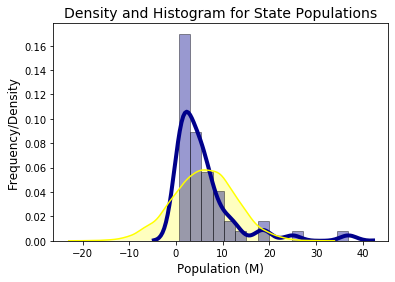

In [355]:
# Density plot and histogram
bin_count = 15
x = ["population_M", "incpp_state_k"]
chart_dat = master_state[x]
x_mu = chart_dat.population_M.mean()
x_std = chart_dat.population_M.std()
chart_title = "Density and Histogram for State Populations"
chart_xax = "Population (M)" 
chart_yax = "Frequency/Density"

sns.distplot(chart_dat.population_M, 
             hist=True, 
             kde=True, 
             bins=bin_count, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title(chart_title, fontsize=14)
plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

x_norm = np.random.normal(loc = x_mu, scale = x_std, size = 5000)
sns.kdeplot(x_norm, color="yellow", shade = True)

plt.show()


#### Display summary statistics for population

In [356]:
desc_population_M = chart_dat.population_M.describe()
desc_population_M

count    51.000000
mean      5.880789
std       6.737994
min       0.556790
25%       1.636703
50%       4.295770
75%       6.560871
max      36.922861
Name: population_M, dtype: float64

#### Plot density and histogram for per capita income by state

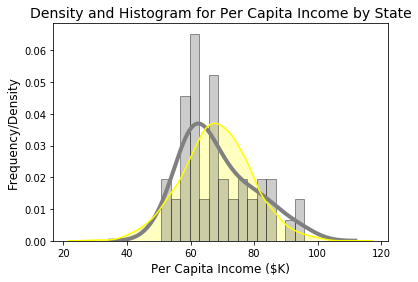

In [357]:
# Density plot and histogram
chart_title = "Density and Histogram for Per Capita Income by State"
chart_xax = "Per Capita Income ($K)" 
chart_yax = "Frequency/Density"
x_mu = chart_dat.incpp_state_k.mean()
x_std = chart_dat.incpp_state_k.std()


sns.distplot(chart_dat.incpp_state_k, 
             hist=True, 
             kde=True, 
             bins=bin_count, 
             color = 'gray', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title(chart_title, fontsize=14)
plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

x_norm = np.random.normal(loc = x_mu, scale = x_std, size = 5000)
sns.kdeplot(x_norm, color="yellow", shade = True)

plt.show()


#### Display summary statistics for per capita income by state

In [358]:
desc_incpp_state_k = chart_dat.incpp_state_k.describe()
desc_incpp_state_k

count    51.000000
mean     68.365882
std      11.029982
min      50.729000
25%      60.070000
50%      66.159000
75%      75.034500
max      95.846000
Name: incpp_state_k, dtype: float64

#### Joint Distribution Between State Population and Per Capita Income, Along with Associated Marginal Distributions


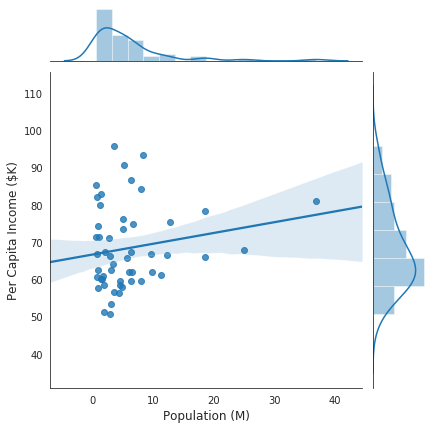

In [359]:
with sns.axes_style("white"):
    sns.jointplot("population_M", "incpp_state_k", 
                  data = master_state, 
                  kind ='reg')

chart_xax = "Population (M)" 
chart_yax = "Per Capita Income ($K)"

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()


#### Run a simple regression

In [360]:
X = master_state["population_M"]
#y = master_state["incpp_state_k"]
y = master_state["income_B"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               income_B   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              3702.
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                    1.48e-48
Time:                        21:38:23   Log-Likelihood:                         -293.23
No. Observations:                  51   AIC:                                      588.5
Df Residuals:                      50   BIC:                                      590.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
population_M    73.5272      1.208     60.844      0.000      71.100      75.954
==============================================================================
Omnibus:                       23.266   Durbin-Watson:                   1.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.529
Skew:                           1.359   Prob(JB):                     3.53e-10
Kurtosis:                       6.619   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Joint Distribution Between State Population and Per Capita Income, Along with Associated Marginal Distributions

There is a lot of clustering for lower state population values. See if a log-transform of the per capita income results in a stronger relationship


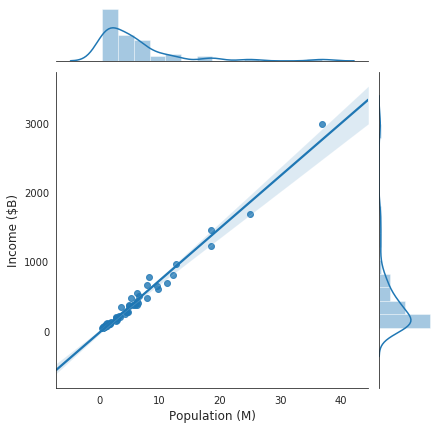

In [361]:
with sns.axes_style("white"):
    sns.jointplot("population_M", "income_B", 
                  data = master_state, 
                  kind ='reg')

chart_xax = "Population (M)" 
chart_yax = "Income ($B)"

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()


#### Run a simple regression

In [362]:
X = master_state["population_M"]
y = master_state["income_B"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               income_B   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              3702.
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                    1.48e-48
Time:                        21:38:24   Log-Likelihood:                         -293.23
No. Observations:                  51   AIC:                                      588.5
Df Residuals:                      50   BIC:                                      590.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
population_M    73.5272      1.208     60.844      0.000      71.100      75.954
==============================================================================
Omnibus:                       23.266   Durbin-Watson:                   1.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.529
Skew:                           1.359   Prob(JB):                     3.53e-10
Kurtosis:                       6.619   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Density and Histogram for Medicare Hospice Patients and All Medicare Patients as a Percentage of State Population


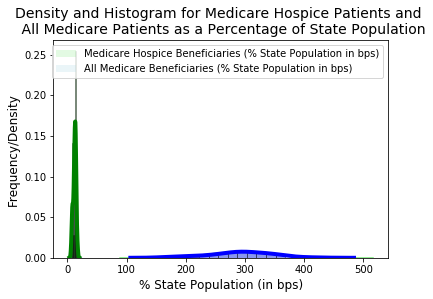

In [363]:
# Density plot and histogram
bin_count = 15
x = ["bps_ben_pop", "bps_ben_hosp_pop"]
chart_dat = master_state[x]
chart_mu = chart_dat.bps_ben_pop.mean()

chart_title = "Density and Histogram for Medicare Hospice Patients and \n All Medicare Patients as a Percentage of State Population"
chart_xax = "% State Population (in bps)" 
chart_yax = "Frequency/Density"

x_norm1 = np.random.normal(loc = chart_dat.bps_ben_pop.mean(),
                           scale = chart_dat.bps_ben_pop.std(),
                           size = 5000)
sns.kdeplot(x_norm1, color="lightgreen", shade = True)

x_norm2 = np.random.normal(loc = chart_dat.bps_ben_hosp_pop.mean(), 
                          scale = chart_dat.bps_ben_hosp_pop.std(), 
                          size = 5000)
sns.kdeplot(x_norm2, color="lightblue", shade = True)

sns.distplot(master_state.bps_ben_pop,
             hist=True, 
             kde=True, 
             bins=bin_count, 
             color = 'blue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(master_state.bps_ben_hosp_pop,
             hist=True, 
             kde=True, 
             bins=bin_count, 
             color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title(chart_title, fontsize=14)
plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.legend(["Medicare Hospice Beneficiaries (% State Population in bps)","All Medicare Beneficiaries (% State Population in bps)"])
plt.show()



#### Summary Statistics for Medicare Hospice Patients and All Medicare Patients as a Percentage of State Population


In [364]:
print("Summary statistics for All Medicare Patients as a Percentage of State Population (bps_ben_pop)")
print(master_state.bps_ben_pop.describe())

print("\nSummary statistics for Medicare Hospice Patients a Percentage of State Population (bps_ben_hosp_pop)")
print(master_state.bps_ben_hosp_pop.describe())

Summary statistics for All Medicare Patients as a Percentage of State Population (bps_ben_pop)
count     51.000000
mean     292.601379
std       52.520728
min      174.642183
25%      268.129552
50%      297.404189
75%      331.732253
max      415.772607
Name: bps_ben_pop, dtype: float64

Summary statistics for Medicare Hospice Patients a Percentage of State Population (bps_ben_hosp_pop)
count    51.000000
mean     12.308822
std       2.405491
min       6.729032
25%      10.924384
50%      12.844372
75%      13.895773
max      17.118175
Name: bps_ben_hosp_pop, dtype: float64


#### Joint Distribution Between Medicare Hospice Patients and All Medicare Patients as a Percentage of State Population, Along with Associated Marginal Distributions

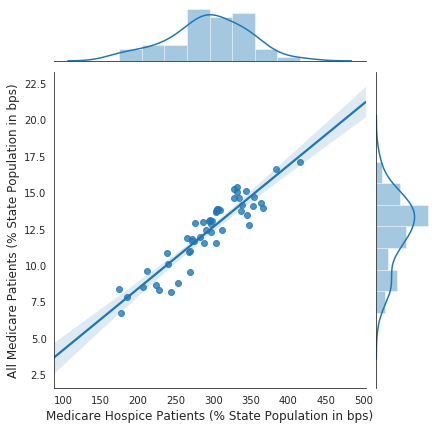

In [365]:
with sns.axes_style("white"):
    sns.jointplot("bps_ben_pop", "bps_ben_hosp_pop", 
                  data = chart_dat, 
                  kind ='reg')

chart_xax = "Medicare Hospice Patients (% State Population in bps)" 
chart_yax = "All Medicare Patients (% State Population in bps)"

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()


#### Joint Distribution Between Medicare Hospice Patients as a Percentage of State Population and Log of Per Capita Income, Along with Associated Marginal Distributions

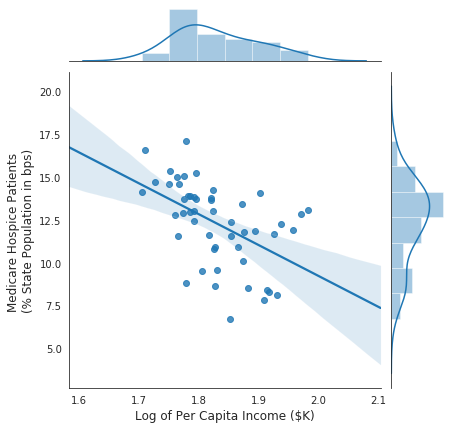

In [366]:
with sns.axes_style("white"):
    sns.jointplot("log_incpp_state_k", "bps_ben_hosp_pop", 
                  data = master_state, 
                  kind ='reg')

chart_xax = "Log of Per Capita Income ($K)"
chart_yax = "Medicare Hospice Patients \n(% State Population in bps)" 

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()


#### Run a simple regression

In [367]:
X = master_state["log_incpp_state_k"]
y = master_state["bps_ben_hosp_pop"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       bps_ben_hosp_pop   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              1078.
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                    1.69e-35
Time:                        21:38:26   Log-Likelihood:                         -121.87
No. Observations:                  51   AIC:                                      245.7
Df Residuals:                      50   BIC:                                      247.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_incpp_state_k     6.6945      0.204     32.831      0.000       6.285       7.104
==============================================================================
Omnibus:                        1.594   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.503
Skew:                          -0.312   Prob(JB):                        0.472
Kurtosis:                       2.436   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comparing Hospice Rates of Top and Bottom Quartile States by Log of Per Capita Income

In [368]:
# Split master_state dataframe into quantiles based on per capita income

# Define quartiles
master_state_qtls = master_state.quantile([.25, .5, .75, 1], axis = 0)
master_state_qtls.reset_index(inplace=True)

# Extract Per Capita Income bottom and top quartile thresholds
q25 = master_state_qtls.loc[0, "log_incpp_state_k"]
q75 = master_state_qtls.loc[2, "log_incpp_state_k"]

# Create top and bottom quartile data sets based on Per Capita Income
master_state_25q = master_state[master_state.log_incpp_state_k < q25]
master_state_75q = master_state[master_state.log_incpp_state_k >= q75]


### Top Quartile States by Log of Per Capita Income
#### Joint Distribution Between Medicare Hospice Patients as a Percentage of State Population and Log of Per Capita Income, Along with Associated Marginal Distributions

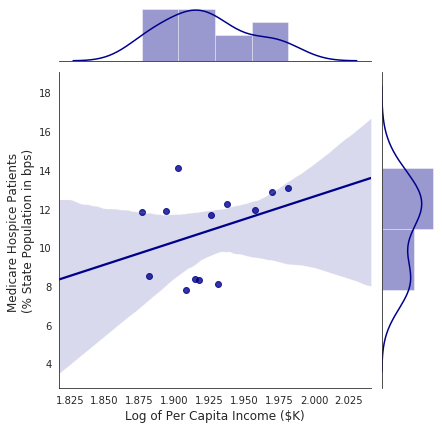

In [369]:
with sns.axes_style("white"):
    sns.jointplot("log_incpp_state_k", "bps_ben_hosp_pop", 
                  data = master_state_75q, 
                  color = "darkblue",
                  kind ='reg')

chart_xax = "Log of Per Capita Income ($K)"
chart_yax = "Medicare Hospice Patients \n(% State Population in bps)" 

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()


#### Top Quartile Descriptive Statistics

In [370]:
master_state_75q.describe()

,ssa_state_code,population,income,incpp_state,ben_count_total,ben_count_hospice,pct_hospice,bps_ben_pop,bps_ben_hosp_pop,incpp_state_k,log_incpp_state_k,log_incpp_state,population_M,income_B
count,13.000000,1.300000e+01,1.300000e+01,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,18.538462,8.340617e+06,6.851768e+11,83978.578519,20243.538462,866.615385,4.177538,259.521989,10.824173,83.978538,1.923048,4.923048,8.340617,685.176794
std,13.973877,1.003591e+07,8.035615e+11,6334.118025,20226.528573,871.916905,0.370693,50.535258,2.232737,6.334151,0.032339,0.032339,10.035915,803.561548
min,2.000000,5.782150e+05,4.934662e+10,75243.221378,1228.000000,47.000000,3.328612,174.642183,7.810879,75.243000,1.876467,4.876467,0.578215,49.346623
25%,7.000000,1.339090e+06,1.108377e+11,79906.722961,4341.000000,173.000000,4.122333,227.318552,8.390789,79.907000,1.902583,4.902583,1.339090,110.837746
50%,14.000000,5.220219e+06,4.732446e+11,82770.945853,14754.000000,623.000000,4.222584,271.327447,11.804658,82.771000,1.917878,4.917878,5.220219,473.244603
75%,30.000000,8.338282e+06,7.785003e+11,86565.172593,24820.000000,1071.000000,4.350705,296.028417,12.259992,86.565000,1.937343,4.937343,8.338282,778.500274
max,49.000000,3.692286e+07,2.991316e+12,95846.076791,68621.000000,2884.000000,4.804560,353.552589,14.089979,95.846000,1.981574,4.981574,36.922861,2991.316345


#### Run a simple regression

In [371]:
X = master_state_75q["log_incpp_state_k"]
y = master_state_75q["bps_ben_hosp_pop"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       bps_ben_hosp_pop   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              321.8
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                    4.94e-10
Time:                        21:38:27   Log-Likelihood:                         -28.042
No. Observations:                  13   AIC:                                      58.08
Df Residuals:                      12   BIC:                                      58.65
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_incpp_state_k     5.6333      0.314     17.940      0.000       4.949       6.317
==============================================================================
Omnibus:                        3.817   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                1.255
Skew:                          -0.211   Prob(JB):                        0.534
Kurtosis:                       1.538   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bottom Quartile States by Per Capita Income
#### Joint Distribution Between Medicare Hospice Patients as a Percentage of State Population and Log of Per Capita Income, Along with Associated Marginal Distributions

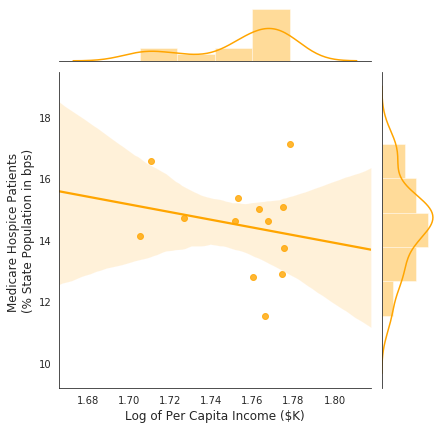

In [372]:
with sns.axes_style("white"):
    sns.jointplot("log_incpp_state_k", "bps_ben_hosp_pop", 
                  data = master_state_25q, 
                  color = "orange",
                  kind ='reg')

chart_xax = "Log of Per Capita Income ($K)"
chart_yax = "Medicare Hospice Patients \n(% State Population in bps)" 

plt.xlabel(chart_xax, fontsize=12)
plt.ylabel(chart_yax, fontsize=12)

plt.show()

#### Bottom Quartile Descriptive Statistics

In [373]:
master_state_25q.describe()

,ssa_state_code,population,income,incpp_state,ben_count_total,ben_count_hospice,pct_hospice,bps_ben_pop,bps_ben_hosp_pop,incpp_state_k,log_incpp_state_k,log_incpp_state,population_M,income_B
count,13.000000,1.300000e+01,1.300000e+01,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,27.230769,3.640777e+06,2.093964e+11,56902.839636,12015.000000,527.076923,4.291683,337.985269,14.474926,56.902769,1.754493,4.754493,3.640777,209.396369
std,14.906116,2.041744e+06,1.239180e+11,3158.079281,6560.829483,300.066787,0.301027,35.204765,1.516692,3.158019,0.024800,0.024800,2.041744,123.917969
min,1.000000,8.997120e+05,5.180438e+10,50728.869266,3130.000000,115.000000,3.674121,276.275273,11.542308,50.729000,1.705255,4.705255,0.899712,51.804377
25%,19.000000,1.851957e+06,1.052277e+11,56421.216129,7111.000000,307.000000,4.152518,327.986154,13.747655,56.421000,1.751442,4.751442,1.851957,105.227710
50%,27.000000,3.436474e+06,1.946751e+11,57989.813024,11384.000000,528.000000,4.365052,334.910854,14.619032,57.990000,1.763352,4.763352,3.436474,194.675129
75%,37.000000,4.555985e+06,2.668940e+11,59493.371100,14943.000000,666.000000,4.517743,347.889102,15.078845,59.493000,1.774469,4.774469,4.555985,266.893986
max,51.000000,7.964801e+06,4.745608e+11,60033.378395,27343.000000,1201.000000,4.662288,415.772607,17.118175,60.033000,1.778393,4.778393,7.964801,474.560800


#### Run a simple regression

In [374]:
X = master_state_25q["log_incpp_state_k"]
y = master_state_25q["bps_ben_hosp_pop"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       bps_ben_hosp_pop   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1102.
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                    3.53e-13
Time:                        21:38:29   Log-Likelihood:                         -23.800
No. Observations:                  13   AIC:                                      49.60
Df Residuals:                      12   BIC:                                      50.17
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_incpp_state_k     8.2464      0.248     33.203      0.000       7.705       8.788
==============================================================================
Omnibus:                        0.225   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.158
Skew:                          -0.194   Prob(JB):                        0.924
Kurtosis:                       2.624   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""